## Imports

In [1]:
import numpy as np

# To load .arff files
import arff

# Plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('retina')
plt.rc('figure', figsize=[7, 7])
plt.rc('font', size=14)

# For splitting the dataset into train and explain
import random
random.seed(42)

# Required imports
from src.XPLAIN_explainer import XPLAIN_explainer
from src.dataset import Dataset

/mnt/c/Users/andre/Desktop/tirocinio/src/../


## Fetching data and preprocessing

For this tutorial, we will be using the [Monks](https://www.openml.org/d/333) dataset.

### Why Monks

Monks is an artificial dataset, where the class: `target` is the result of this logical expression

`target: (attr1 == attr2) || (attr5 == 1)`

We have chosen this dataset because there is an interaction between `attr1` and `attr2`. Advanced classifiers will learn this interaction while simpler ones will only consider `attr5`.

Let's fetch the dataset from OpenML

In [2]:
from sklearn.datasets import fetch_openml
raw_dataset = fetch_openml(data_id=333)

### Data format

We preprocess the data to obtain a format suitable for the analysis.

`Xy` is a matrix containing features and class for each row of the dataset

In [3]:
Xy = np.hstack((
    (np.array(raw_dataset['data']).astype(int) + 1).astype(str),
    np.array(raw_dataset['target']).reshape((-1, 1)).astype(str)
))

Xy[:5]

array([['1', '1', '1', '1', '3', '1', '1'],
       ['1', '1', '1', '1', '3', '2', '1'],
       ['1', '1', '1', '3', '2', '1', '1'],
       ['1', '1', '1', '3', '3', '2', '1'],
       ['1', '1', '2', '1', '2', '1', '1']], dtype='<U21')

`attributes` is an ordered list of tuples describing the possible values of each column

In [4]:
attributes = [
    (k, np.array(v).astype(str))
    for k,v in raw_dataset['categories'].items()
] + [('target', np.unique(raw_dataset['target']).astype(str))]

attributes

[('attr1', array(['1', '2', '3'], dtype='<U1')),
 ('attr2', array(['1', '2', '3'], dtype='<U1')),
 ('attr3', array(['1', '2'], dtype='<U1')),
 ('attr4', array(['1', '2', '3'], dtype='<U1')),
 ('attr5', array(['1', '2', '3', '4'], dtype='<U1')),
 ('attr6', array(['1', '2'], dtype='<U1')),
 ('target', array(['0', '1'], dtype='<U1'))]

### The `Dataset` class

With the data in this format, we can finally create the `Dataset` object.

In [5]:
dataset = Dataset(Xy, attributes)

### Splitting the dataset into `train` and `explain`

We then will split the dataset into `train_dataset` and `explain_dataset`. The train dataset will be used to create the locality for the L3 classifier. The explain dataset will be used to test the method's ability to generate explanations.

In [6]:
def train_explain_split(dataset):
    dataset_len = len(dataset)
    train_indices = list(range(dataset_len))

    explain_indices = list(
        random.sample(train_indices, round(dataset_len * 0.25)))
        
    for i in explain_indices:
        train_indices.remove(i)

    train_dataset = Dataset.from_indices(train_indices, dataset)
    explain_dataset = Dataset.from_indices(explain_indices, dataset)

    return train_dataset, explain_dataset

In [7]:
train_dataset, explain_dataset = train_explain_split(dataset)

## Training a classifier

Let's use Scikit-learn's Categorical Naive Bayes classifer. Naive Bayes classifiers consider all the features as independent, hence we should never see an explanation where the interaction between two features is important.

In [8]:
from sklearn.naive_bayes import CategoricalNB

clf = CategoricalNB()
clf = clf.fit(train_dataset.X_numpy(), train_dataset.Y_numpy())

## Evaluating the classifier's performance

In [9]:
from sklearn.metrics import accuracy_score

Y_pred = clf.predict(explain_dataset.X_numpy())
accuracy_score(explain_dataset.Y_numpy(), Y_pred)

0.7338129496402878

## Explaining predictions

To explain a prediction we need to instantiate a `XPLAIN_explainer` object.

In [10]:
explainer = XPLAIN_explainer(clf, train_dataset)

Then, we pick an instance which we want to explain with respect to a class. Let's pick instance `4` and class: `'1'`

In [11]:
explain_dataset.get_decoded(4)

attr1     1
attr2     3
attr3     1
attr4     2
attr5     1
attr6     1
target    1
Name: 228, dtype: object

This instance has class `1` because `attr5 == 1`, while `attr1 != attr2`. (Recall the rule `target: (attr1 == attr2) || (attr5 == 1)`)

To explain an instance, we need to pass its *encoded* form to `explain_instance`. The encoded form can be obtained from a dataset object using the attribute syntax: `dataset[instance_index]`.

In [12]:
instance = explain_dataset[4]
class_ = '1'

In [13]:
explanation = explainer.explain_instance(instance, class_)
explanation

compute_lace_step k=20
compute_lace_step k=40
compute_lace_step k=60
compute_lace_step k=80
compute_lace_step k=100
compute_lace_step k=120
compute_lace_step k=140
compute_lace_step k=160
compute_lace_step k=180
compute_lace_step k=200
explain_instance errors: 5.870E-02, 5.870E-02, 5.870E-02, 5.870E-02, 5.870E-02, 5.870E-02, 5.870E-02, 5.870E-02, 5.870E-02, 5.870E-02


{'XPLAIN_explainer_o': <src.XPLAIN_explainer.XPLAIN_explainer at 0x7f3e4d6d5b70>,
 'diff_single': [-0.0043078866498516,
  -0.000924579280960014,
  -0.0006868395944223948,
  -0.005513141681877443,
  0.5664958295415631,
  -0.0008304050766636539],
 'map_difference': {'5': 0.5681447767652239},
 'k': 200,
 'error': 0.058702652938482314,
 'instance': attr1     1
 attr2     3
 attr3     1
 attr4     2
 attr5     1
 attr6     1
 target    1
 dtype: object,
 'target_class': '1',
 'errors': [0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314],
 'instance_class_index': 1,
 'prob': 0.985011402022745}

## Visualizing explanations

The explanations can be visualized using a bar plot

In [14]:
def plot(e):
    fig, pred_ax = plt.subplots(1, 1)
    
    attrs = [f"{k}" for k,v in (e['instance'].items())][:-1]
    values = [f"{k}={v}" for k,v in (e['instance'].items())]
    nls = ", ".join(values)
    
    pred_ax.set_title(
f"""Importance
P[target={e['target_class']} | x=({nls})]={e['prob']:.3f}""", pad=12
    )
    pred_ax.set_ylabel("Attribute or rule", labelpad=2)
    pred_ax.set_xlabel(
        fr"${e['prob']:.3f} - P[y={e['target_class']} | x A_i]$",
        labelpad=12
    )
    
    pred_ax.set_axisbelow(True)
    pred_ax.grid(b=True)
    
    pred_ax.barh(
        attrs + [
            ",".join([
                f"{(list(e['instance'].to_dict().items())[int(a)-1])[0]}"
                for a in ats.split(',')
            ])
            for ats in e['map_difference'].keys()],
        width=e['diff_single'] + list(e['map_difference'].values())
    )

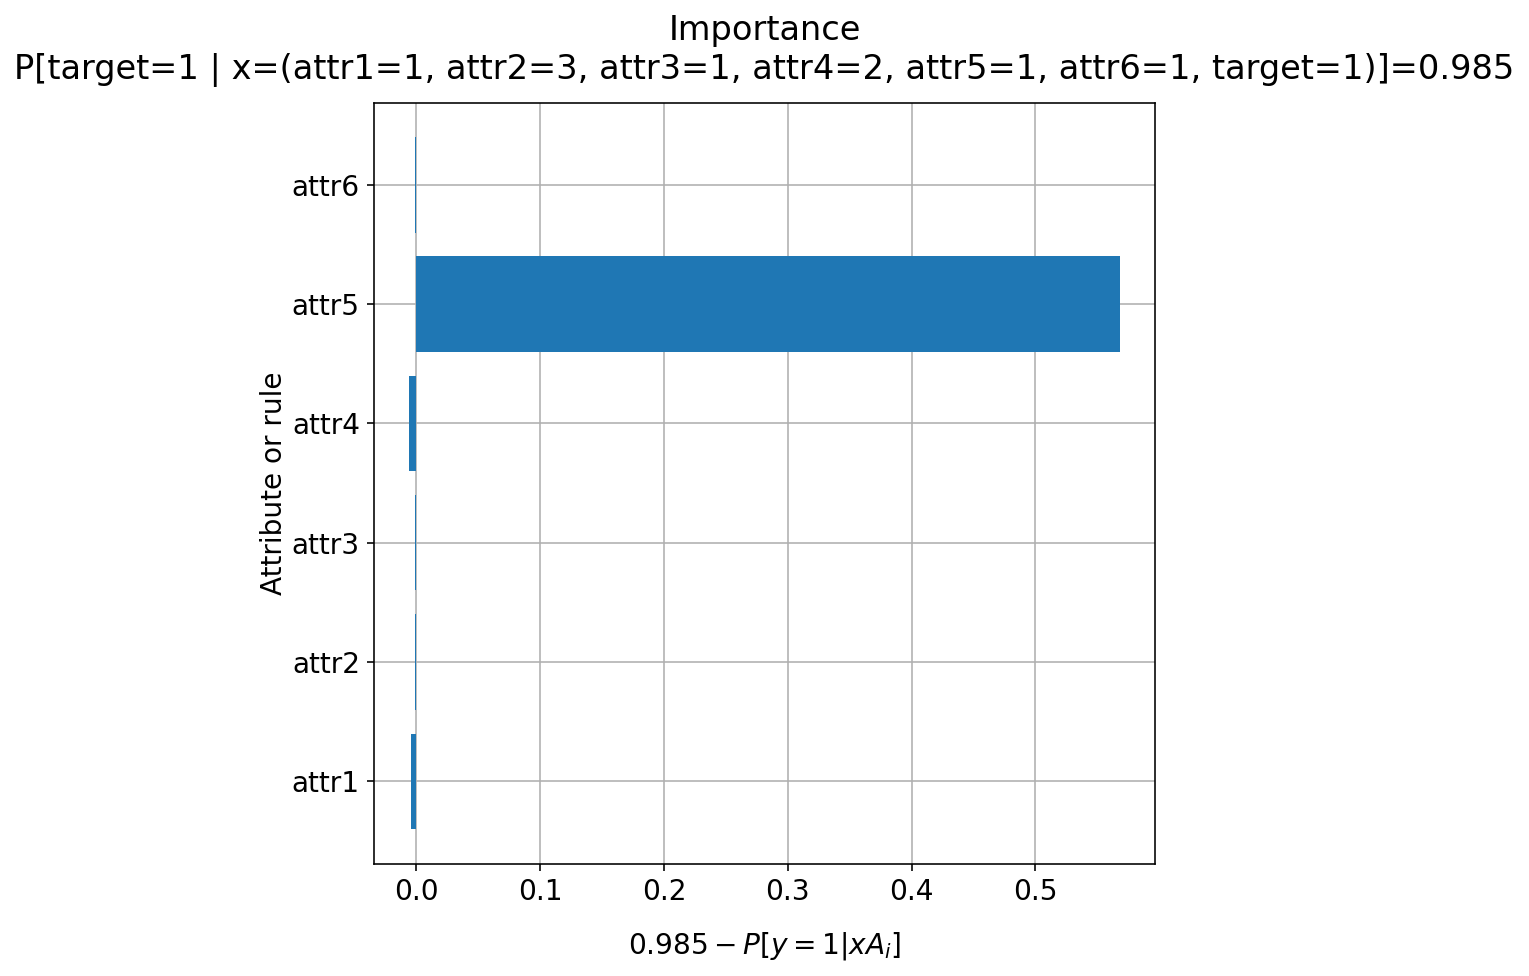

In [15]:
plot(explanation)

## More instances

For this instance `attr1!=attr2` and `attr5!=1` thus `target=0`. Notice how the a rule with both `attr1` and `attr2` in its body does not appear. Therefore the classifier has decided that `target=0` only because of `attr5`.

attr1     1
attr2     2
attr3     2
attr4     3
attr5     3
attr6     2
target    0
Name: 25, dtype: object
compute_lace_step k=20
compute_lace_step k=40
compute_lace_step k=60
compute_lace_step k=80
compute_lace_step k=100
compute_lace_step k=120
compute_lace_step k=140
compute_lace_step k=160
compute_lace_step k=180
compute_lace_step k=200
explain_instance errors: 1.949E-01, 1.949E-01, 1.949E-01, 1.949E-01, 1.949E-01, 1.949E-01, 1.949E-01, 1.949E-01, 3.708E-02, 3.708E-02


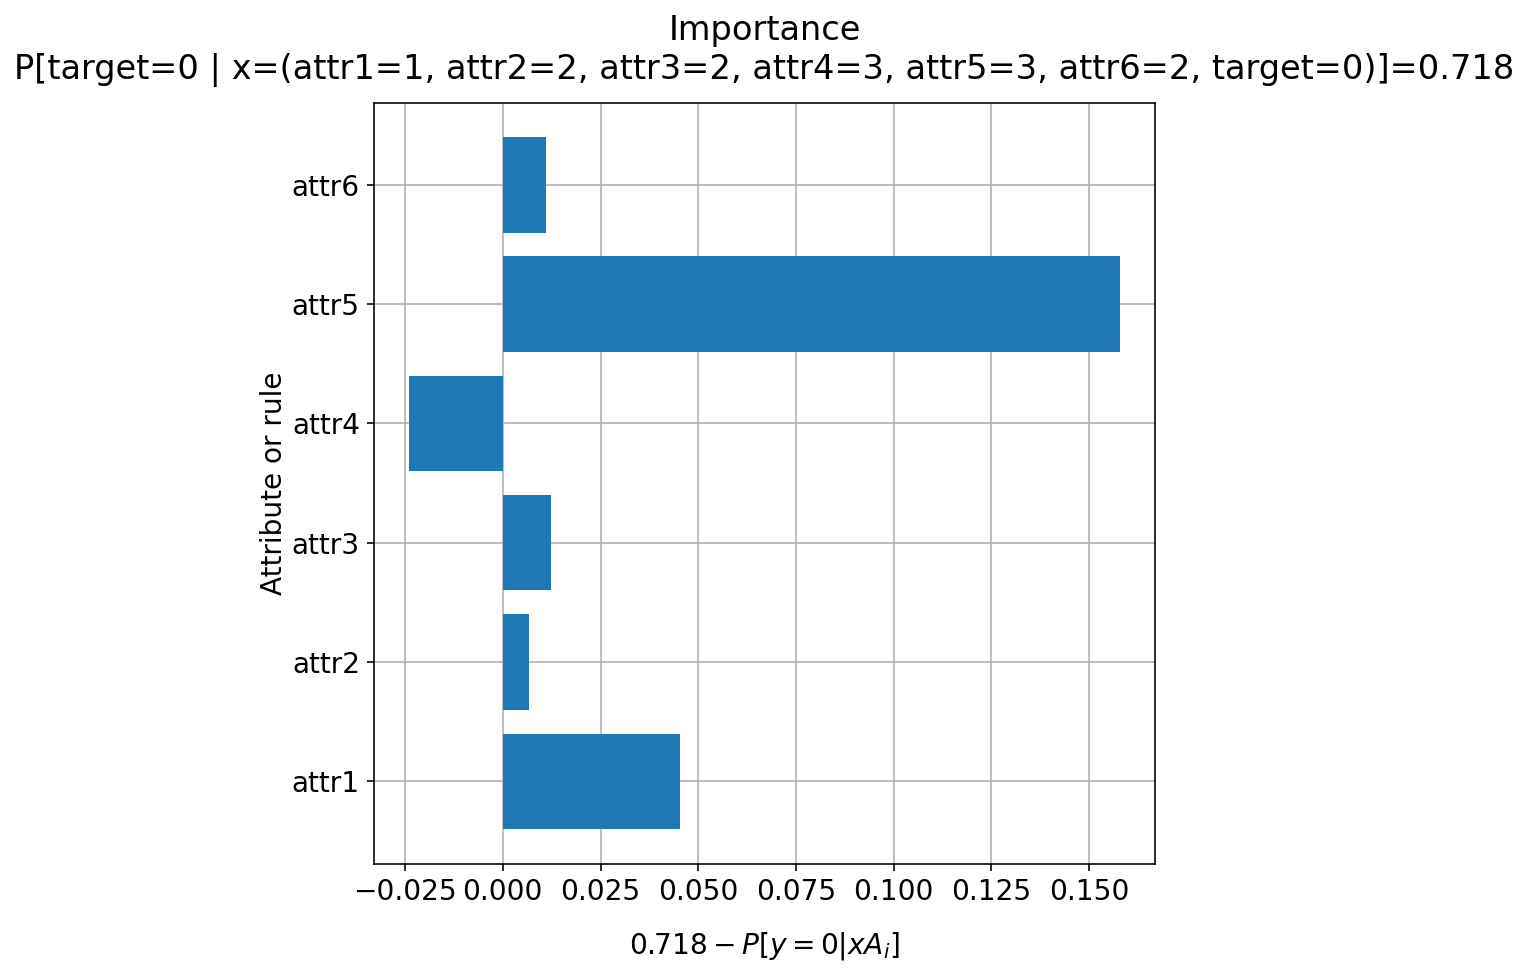

In [16]:
instance = explain_dataset[1]
class_ = '0'
print(explain_dataset.get_decoded(1))
explanation = explainer.explain_instance(instance, class_)
plot(explanation)

We can confirm our hypothesis by analyzing the probabilities associated to each feature value of the classifier

In [17]:
np.exp(clf.feature_log_prob_[4]) # feature 'e'

array([[0.0045045 , 0.35135135, 0.33783784, 0.30630631],
       [0.4729064 , 0.15270936, 0.18226601, 0.19211823]])

$$P[target=0|attr5=1]$$

In [18]:
np.exp(clf.feature_log_prob_[4][0][0])

0.004504504504504505

$$P[target=1|attr5=1]$$

In [19]:
np.exp(clf.feature_log_prob_[4][1][0])

0.47290640394088673

## More classifiers

Let's explain the previous instance by using a more powerful model: a neural network.

Again we train the classifier

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

clf = make_pipeline(
    OneHotEncoder(),
    MLPClassifier(
        random_state=42,
        max_iter=1000,
        hidden_layer_sizes=(3,)
    ))

clf = clf.fit(train_dataset.X_numpy(), train_dataset.Y_numpy())

/home/andrea/venv-environments/lace/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


See that it is much more accurate

In [21]:
from sklearn.metrics import accuracy_score

Y_pred = clf.predict(explain_dataset.X_numpy())
accuracy_score(explain_dataset.Y_numpy(), Y_pred)

1.0

Instantiate a new explainer for this new classifier and ask for an explanation on why instance 14 was classfied as `1`.

attr1     3
attr2     3
attr3     1
attr4     2
attr5     1
attr6     2
target    1
Name: 517, dtype: object
compute_lace_step k=20
compute_lace_step k=40
compute_lace_step k=60
explain_instance errors: 4.070E-01, 4.070E-01, 1.470E-02


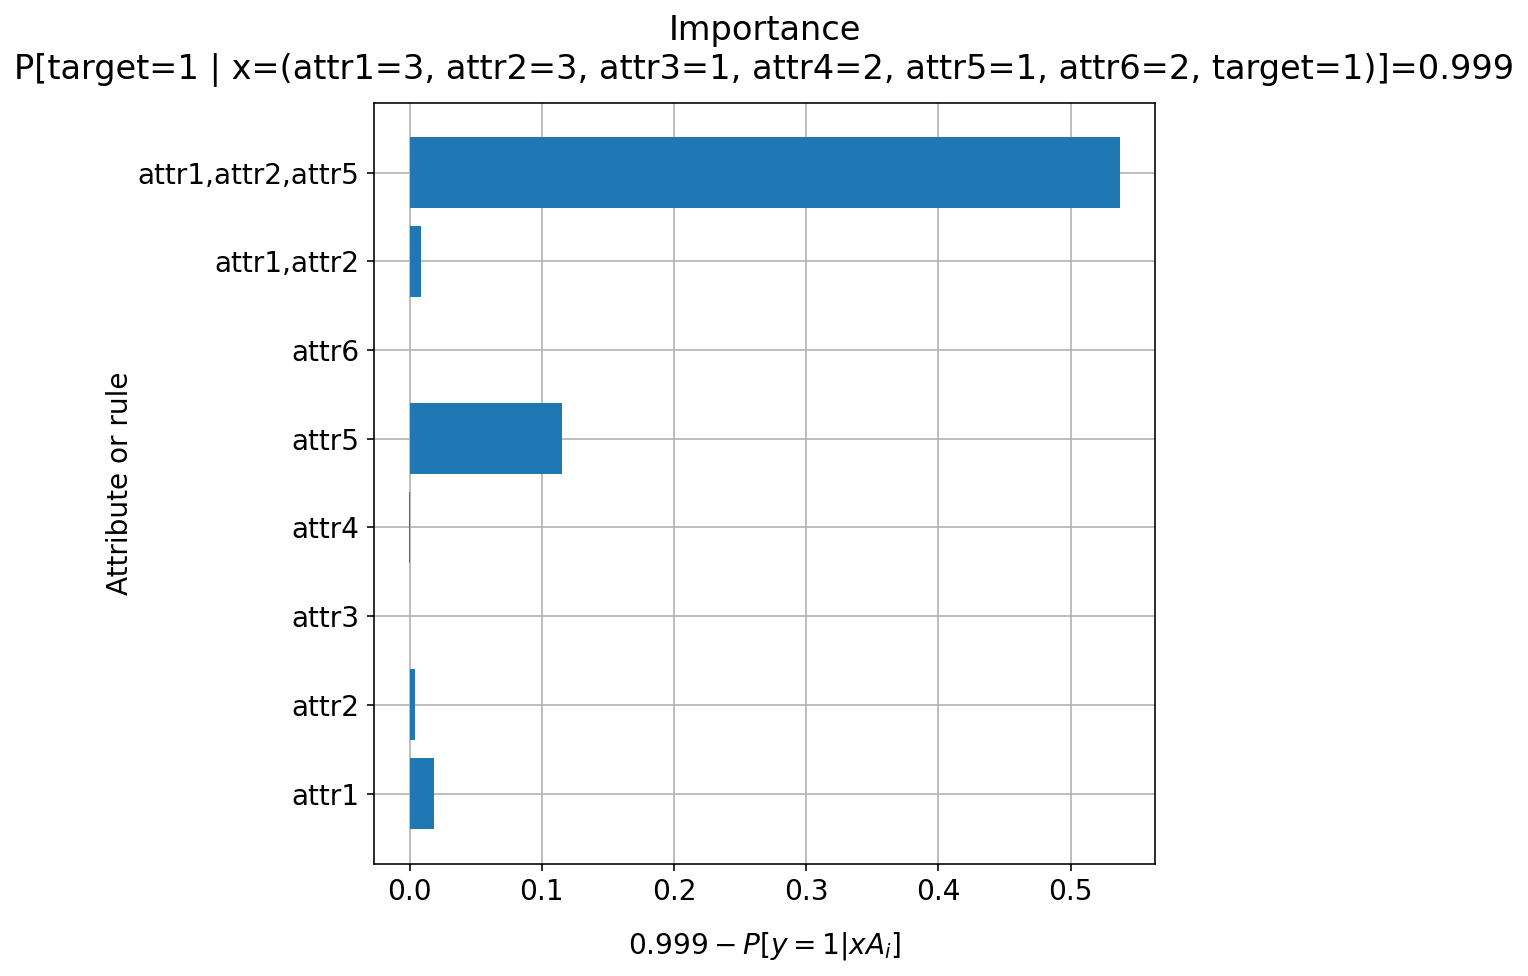

In [22]:
explainer = XPLAIN_explainer(clf, train_dataset)

instance = explain_dataset[14]
class_ = '1'

print(explain_dataset.get_decoded(14))

explanation = explainer.explain_instance(instance, class_)

plot(explanation)

We can see that the neural network consider the combination of attributes 1,2,5 as the most imporant feature. This can be used as an indicator that it has generalized correctly and doesn't simply overfit the dataset.